In [1]:
from keras.models import load_model
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

Using TensorFlow backend.


In [2]:
import nltk
from nltk.util import ngrams
import spacy 
import numpy
import pandas as pd
import seaborn as sns

/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [3]:
#spacy.__path__

In [55]:
#%%time
#nlp=spacy.load('en_vectors_web_lg')
%time nlp=spacy.load('./wikipedia-pubmed-and-PMC-w2v')
%time model=load_model('./model/lstm.h5')

CPU times: user 45.8 s, sys: 5min 15s, total: 6min 1s
Wall time: 6min 1s
CPU times: user 19.9 s, sys: 1min 13s, total: 1min 33s
Wall time: 1min 27s


In [56]:
def get_features(docs, max_length):
    docs = list(docs)
    Xs = numpy.zeros((len(docs), max_length), dtype='int32')
    for i, doc in enumerate(docs):
        j = 0
        for token in doc:
            ##rever to word vector
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs

In [57]:
le = preprocessing.LabelEncoder()
le.classes_ = numpy.load('./model/classes.npy')

### write code for n gram

In [58]:
!grep -rn validation_lines *.ipynb 

downloadFromPMC.ipynb:276:      "validation_lines.txt\r\n",
exportValidation.ipynb:69:    "with open('./Data/validation_lines.txt','w')as f:\n",
nGramClassification_batch.ipynb:117:    "!grep -rn validation_lines *.ipynb "
nGramClassification_batch.ipynb:126:    "with open('./Data/validation_lines.txt') as f:\n",
nGramClassification_batch.ipynb:143:    "#!head ./Data/validation_lines.txt"


In [59]:
with open('./Data/validation_lines.txt') as f:
    lines=f.readlines()

In [60]:
#!head ./Data/validation_lines.txt

In [61]:
print ("out dir: ",os.getcwd()+'/Data/hmaps_batch/')

out dir:  /data/cellardata/users/btsui/DEEP_NLP/NLP_spacy/Data/hmaps_batch/


In [62]:
#sent='Large outbreak of pre-XDR TB Argentina'
"""
for i_line,sent in enumerate(tqdm(lines)):

    tokens=sent.split(' ')
    s=sent.split(' ')

    scoreDf=pd.DataFrame(columns=le.classes_,index=tokens).fillna(0)
    #for n_gram in range(1,len(tokens)+1):
    for n_gram in range(1,len(tokens)):
        grams=list(map(lambda L:" ".join(L),list(ngrams(s,n_gram))))
        #print (grams)
        val_docs = list(nlp.pipe(grams))
        val_X=get_features(val_docs,max_length=model.input_shape[1])
        tmpDf=pd.DataFrame(data=model.predict_proba(val_X),columns=le.classes_,index=grams)
        
        #each n gram only advange 
        for i,gram in enumerate(tmpDf.index):# for ec
            for j,one_gram in enumerate(gram.split(' ')):
                scoreDf.iloc[i+j]=numpy.maximum(scoreDf.iloc[i+j],(tmpDf.iloc[i]))
                
    displayHmap=scoreDf.T
    fig,ax=plt.subplots(figsize=(10,5))
    #displayHmap[displayHmap.max(axis=1)<0.5]=0
    sns.heatmap(data=displayHmap,ax=ax,cbar_kws={'label':'Probability score'},annot=True)
    ax.set_ylabel('entites')
    ax.set_xlabel('words in sentence')
    fig.savefig('./Data/hmaps_batch/{}.pdf'.format(i_line),bbox_inches='tight')
    break
    plt.clf()
"""

'\nfor i_line,sent in enumerate(tqdm(lines)):\n\n    tokens=sent.split(\' \')\n    s=sent.split(\' \')\n\n    scoreDf=pd.DataFrame(columns=le.classes_,index=tokens).fillna(0)\n    #for n_gram in range(1,len(tokens)+1):\n    for n_gram in range(1,len(tokens)):\n        grams=list(map(lambda L:" ".join(L),list(ngrams(s,n_gram))))\n        #print (grams)\n        val_docs = list(nlp.pipe(grams))\n        val_X=get_features(val_docs,max_length=model.input_shape[1])\n        tmpDf=pd.DataFrame(data=model.predict_proba(val_X),columns=le.classes_,index=grams)\n        \n        #each n gram only advange \n        for i,gram in enumerate(tmpDf.index):# for ec\n            for j,one_gram in enumerate(gram.split(\' \')):\n                scoreDf.iloc[i+j]=numpy.maximum(scoreDf.iloc[i+j],(tmpDf.iloc[i]))\n                \n    displayHmap=scoreDf.T\n    fig,ax=plt.subplots(figsize=(10,5))\n    #displayHmap[displayHmap.max(axis=1)<0.5]=0\n    sns.heatmap(data=displayHmap,ax=ax,cbar_kws={\'label\':

In [63]:
#lines[2]

In [64]:
#docs=nlp.pipe(['TP53'])

### take SRS titles for classification

In [65]:
%%time 
inS_dir='/cellar/users/btsui/Data/nrnb01_nobackup/METAMAP/allSRS.pickle'

srsS=pd.read_pickle(inS_dir)
srsS=pd.Series(data=srsS.values,index=pd.MultiIndex.from_arrays([srsS.index.get_level_values(0),
                                                            srsS.index.get_level_values(1).str.lower()]) )
#technical_meta_data_df=pd.read_pickle(sra_dump_pickle_dir)

CPU times: user 42.7 s, sys: 7.49 s, total: 50.2 s
Wall time: 50.2 s


In [66]:
specie_m=srsS.isin(['Mus musculus','Homo sapiens'])

In [67]:
attrib_m=srsS.index.get_level_values(1)=='scientific_name'

In [68]:
mySpecieSrs=srsS[specie_m&attrib_m].index.get_level_values(0).unique()

In [69]:
specie_srs_m=srsS.index.get_level_values(0).isin(mySpecieSrs)

In [422]:
attrib_a=srsS.index.get_level_values(1)
attrib_m=attrib_a=='description'


In [423]:
#len_m=srsS.str.count(' ')<10


In [429]:
srsS_sub=srsS[attrib_m&specie_srs_m].drop_duplicates()

blackListItems=['HapMap','1000 genomes']

blacklist_m=srsS_sub.str.contains("|".join(blackListItems))

wordCountS=srsS_sub.str.count(' ')
lem_m=(wordCountS<20)&(wordCountS>2)
srsS_sub=srsS_sub[lem_m&(~blacklist_m)]



In [434]:
srsS_sub[srsS_sub.str.contains('endometrial stromal sarcoma cell ',case=False)]

In [436]:
inTestStrS=srsS_sub.sample(n=100,random_state=0)

#### get baseline empty state

In [437]:
val_docs = list(nlp.pipe(' '))
val_X=get_features(val_docs,max_length=model.input_shape[1])

emptyState=model.predict_proba(val_X)[0,:]

In [438]:
emptyState

array([0.4080381 , 0.42621672, 0.37912756, 0.6670608 , 0.3285981 ,
       0.30375874], dtype=float32)

In [439]:
"""val_docs = list(nlp.pipe('male'))
val_X=get_features(val_docs,max_length=model.input_shape[1])

emptySexState=model.predict_proba(val_X)[0,:]"""

"val_docs = list(nlp.pipe('male'))\nval_X=get_features(val_docs,max_length=model.input_shape[1])\n\nemptySexState=model.predict_proba(val_X)[0,:]"

In [440]:
emptySexState

array([0.00195959, 0.00214041, 0.00026779, 0.01843335, 0.00211464,
       0.15076971], dtype=float32)

In [441]:
import re

In [442]:
#sent=inTestStrS.iloc[20]#lines[10]
#sent=sent.replace('.\n','')
#print (sent)
"""
displayHmap=scoreDf.T
fig,ax=plt.subplots(figsize=(10,5))
#displayHmap[displayHmap.max(axis=1)<0.5]=0
sns.heatmap(data=displayHmap,ax=ax,cbar_kws={'label':'Probability score'},annot=True)
ax.set_ylabel('entites')
ax.set_xlabel('words in sentence')
"""
myML=[]
for sent in tqdm(inTestStrS):
    sent=re.sub(r'[^a-zA-Z0-9 ]+', ' ', sent)
    #print (sent)
    tokens=re.split(pattern=' ',string=sent.lower())
    s=tokens
    #print (tokens)
    scoreDf=pd.DataFrame(columns=le.classes_,index=tokens).fillna(0)
    #for n_gram in range(1,len(tokens)+1):
    for n_gram in range(1,len(tokens)):
        grams=list(map(lambda L:" ".join(L),list(ngrams(s,n_gram))))
        #print (grams)
        val_docs = list(nlp.pipe(grams))
        val_X=get_features(val_docs,max_length=model.input_shape[1])
        predictM=model.predict_proba(val_X)
        
        tmpDf=pd.DataFrame(data=predictM,columns=le.classes_,index=grams)
        empty_mask=(tmpDf-emptyState).abs().sum(axis=1)<0.1
        tmpDf[empty_mask]=0
        #each n gram only advange 
        for i,gram in enumerate(tmpDf.index):# for ec
            for j,one_gram in enumerate(gram.split(' ')):
                scoreDf.iloc[i+j]=numpy.maximum(scoreDf.iloc[i+j],(tmpDf.iloc[i]))
    myML.append(scoreDf)









  0%|          | 0/100 [00:00<?, ?it/s]






  1%|          | 1/100 [00:00<00:13,  7.25it/s]






  2%|▏         | 2/100 [00:00<00:13,  7.28it/s]






  3%|▎         | 3/100 [00:01<00:41,  2.35it/s]






  4%|▍         | 4/100 [00:02<01:00,  1.59it/s]






  5%|▌         | 5/100 [00:02<00:50,  1.90it/s]






  6%|▌         | 6/100 [00:02<00:44,  2.12it/s]






  7%|▋         | 7/100 [00:05<01:07,  1.38it/s]






  8%|▊         | 8/100 [00:05<01:02,  1.47it/s]






  9%|▉         | 9/100 [00:05<00:56,  1.61it/s]






 10%|█         | 10/100 [00:05<00:52,  1.73it/s]






 11%|█         | 11/100 [00:06<00:48,  1.83it/s]






 12%|█▏        | 12/100 [00:06<00:46,  1.90it/s]






 13%|█▎        | 13/100 [00:06<00:45,  1.93it/s]






 14%|█▍        | 14/100 [00:07<00:46,  1.85it/s]






 15%|█▌        | 15/100 [00:07<00:44,  1.91it/s]






 16%|█▌        | 16/100 [00:08<00:46,  1.80it/s]






 17%|█▋        | 17/100 [00:09<00:47,  1.74it/s]






 18%|█▊        | 18/1

KeyboardInterrupt: 

In [443]:
mergedDf=pd.concat(myML,keys=inTestStrS.values)

In [444]:
#mergedDf

In [445]:
mergedSubDf=mergedDf#.loc[:,mergedDf.columns!='age']

In [446]:
threshold=0.5000001
#mergedSubDf[mergedSubDf<=threshold]=0
mergedSubDf['undetected']=threshold

#

In [447]:
mergedSubDf.idxmax(axis=1).to_frame()

0
Primary tumor of Patient 60                        primary     undetected
                                                   tumor          disease
                                                   of          undetected
                                                   patient     undetected
                                                   60          undetected
source: leukemia cell line                         source         disease
                                                                  disease
                                                   leukemia       disease
                                                   cell         cell type
                                                   line        undetected
Huntington''s disease subject 1752 - Huntington... huntington     disease
                                                   s              disease
                                                   disease        disease
                                                   subject        disease
                                                   1752           disease
                                                                  disease
                                                                  disease
                                                   huntington     disease
                                                   s              disease
                                                   disease        disease
                                                   subject        disease
                                                   analyzed       disease
                                                   for            disease
                                                   htt           genotype
                                                   haplotype     genotype
                                                   1752          genotype
mtDNA sequence reads from ancient dental calcul... mtdna       undetected
                                                   sequence    undetected
                                                   reads       undetected
                                                   from        undetected
...                                                                   ...
Homo sapiens HEK293 immortalized cell line deri... stably        genotype
                                                   expressing    genotype
                                                   n           undetected
                                                   terminal      genotype
                                                   egfp          genotype
                                                   zfp64         genotype
                                                   fusion        genotype
                                                   protein     undetected
Huntington''s disease subject 2920 - Huntington... huntington     disease
                                                   s              disease
                                                   disease        disease
                                                   subject        disease
                                                   2920           disease
                                                                  disease
                                                                  disease
                                                   huntington     disease
                                                   s              disease
                                                   disease        disease
                                                   subject        disease
                                                   analyzed       disease
                                                   for            disease
                                                   htt           genotype
                                                   haplotype     genotype
  

In [380]:
import numpy as np

In [111]:
#replace with duplicated states
#emptyStat=np.array([0.42332533, 0.4360587 , 0.61020947, 0.42082471, 0.4110575 ,
#       0.42533568, 0.47932082])

In [112]:
emptyState=mergedSubDf.groupby(mergedSubDf.columns.tolist(),as_index=False).size().sort_values().index[-1]
#emptyStat=np.array([0.42332533, 0.4360587 , 0.61020947, 0.42082471, 0.4110575 ,
#       0.42533568, 0.47932082])
print (emptyState)

(0.40803810954093933, 0.426216721534729, 0.379127562046051, 0.6670607924461365, 0.32859811186790466, 0.3037587106227875)


In [113]:
noPredM=((mergedSubDf-emptyState).abs()<0.1).all(axis=1)
mergedSubDf[(~noPredM)&(mergedSubDf>0.5).sum(axis=1)==1]

SCIENTIFIC_NAME  \
Human 1000 genomes individual HG00408              genomes                0.519415   
                                                   individual             0.029581   
endometrial stromal sarcoma cell line:OMC-9        stromal                0.000288   
                                                   sarcoma                0.001415   
                                                   cell                   0.000288   
                                                   OMC                    0.388718   
Normal sample HKNPC-084 (NPC-3)                    Normal                 0.001274   
                                                   NPC                    0.000391   
Human HapMap individual NA20412                    individual             0.013864   
human Cytotoxic T cell (Tc) receptor a/b repert... human                  0.666352   
                                                   cell                   0.002516   
                                                   receptor               0.146164   
Human Foreskin Fibroblasts, uninfected control,... Foreskin               0.011472   
Human 1000 genomes individual HG02078              genomes                0.519415   
                                                   individual             0.029581   
acute myeloid leukemia (FAB M5) cell line:THP-1... acute                  0.011772   
                                                   myeloid                0.000483   
                                                   leukemia               0.000683   
                                                   FAB                    0.004268   
                                                   M5                     0.014990   
                                                                          0.408038   
                                                   cell                   0.000350   
Ire1a knock out islets low glucose                 Ire1a                  0.408038   
                                                   knock                  0.007475   
Input_Normal (B-cell)                              Normal                 0.001274   
                                                   cell                   0.000156   
Human 1000 genomes individual HG03240              genomes                0.519415   
                                                   individual             0.029581   
HCT116 post-xeno 9                                 post                   0.156656   
Human 1000 genomes individual HG01188              genomes                0.519415   
...                                                                            ...   
tdTomato (-) control, MLH1, dimeric off-targets    dimeric                0.456076   
                                                   off                    0.044819   
                                                   targets                0.017717   
lung_esophageal_oe33_cell_line_lung_esophageal_... esophageal             0.006398   
                                                   oe33                   0.408038   
                                                   cell                   0.000156   
                                                   lung                   0.001610   
                                                   esophageal             0.006398   
                                                   adenocarcinoma         0.001127   
CD4+CD25-CD44- naive conventional T cells, anti... CD44                   0.002631   
                                                   cells                  0.000470   
R290-L1-P2-CGATGT-Sequences.txt.gz                 R290                   0.014048   
                                                   CGATGT                 0.146654   
                                                   txt                    0.003376   
C2_MDS-95 at diagnosis                             MDS                    0.001638   
                         

In [114]:
#good examples: HAP1 LMTK3-KO cells, stimulated with WNT3, replicate R2

In [115]:
mergedSubDf.loc['HAP1 CCK4-KO cells, stimulated with RESV, replicate R1']

KeyError: 'the label [HAP1 CCK4-KO cells, stimulated with RESV, replicate R1] is not in the [index]'

In [ ]:
mergedSubDf[].iloc[0].values

In [ ]:
sns.heatmap(data=scoreDf.T)

In [ ]:
##among the ones with >0.5, take the ones that are unique
sns.heatmap(data=(scoreDf>0.6).T)

In [ ]:
sns.heatmap(data=scoreDf.T)

In [ ]:
### among the ones with clear boundry, it can classify well. 


"""
argue that it can salvage the data correctly. Among those sentences, 

take >0.5 as boundary, run top 10000 sentences 
"""
scoreDf

### show one

In [179]:
sent='endometrial stromal sarcoma cell line:OMC-9'#inTestStrS.iloc[5]

print(sent)

endometrial stromal sarcoma cell line:OMC-9	


"break\n\n#each n gram only advange \nfor i,gram in enumerate(tmpDf.index):# for ec\n    for j,one_gram in enumerate(gram.split(' ')):\n        scoreDf.iloc[i+j]=numpy.maximum(scoreDf.iloc[i+j],(tmpDf.iloc[i]))\n"

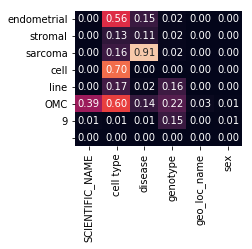

In [203]:
sent=re.sub(r'[^a-zA-Z0-9 ]+', ' ', sent)
#print (sent)
tokens=re.split(pattern=' ',string=sent)
s=tokens
#print (tokens)
scoreDf=pd.DataFrame(columns=le.classes_,index=tokens).fillna(0)
#for n_gram in range(1,len(tokens)+1):
#for n_gram in range(1,len(tokens)):
n_gram=1
grams=list(map(lambda L:" ".join(L),list(ngrams(s,n_gram))))
#print (grams)
val_docs = list(nlp.pipe(grams))
val_X=get_features(val_docs,max_length=model.input_shape[1])
tmpDf=pd.DataFrame(data=model.predict_proba(val_X),columns=le.classes_,index=grams)
#tmpDf=pd.DataFrame(data=predictM,columns=le.classes_,index=grams)
empty_mask=(tmpDf-emptyState).abs().sum(axis=1)<0.01
tmpDf[empty_mask]=0

fig,ax=plt.subplots(figsize=(3,2.5))
sns.heatmap(tmpDf,annot=True,ax=ax,vmin=0,vmax=1.0,fmt='.2f',cbar=None)
#ax.set_xticklabels([])
"""break

#each n gram only advange 
for i,gram in enumerate(tmpDf.index):# for ec
    for j,one_gram in enumerate(gram.split(' ')):
        scoreDf.iloc[i+j]=numpy.maximum(scoreDf.iloc[i+j],(tmpDf.iloc[i]))
"""

### test one

In [261]:
sent=re.sub(r'[^a-zA-Z0-9 ]+', ' ', sent)
#print (sent)
tokens=re.split(pattern=' ',string=sent)
s=tokens
#print (tokens)
scoreDf=pd.DataFrame(columns=le.classes_,index=tokens).fillna(0)
#for n_gram in range(1,len(tokens)+1):
for n_gram in range(1,len(tokens)):
    grams=list(map(lambda L:" ".join(L),list(ngrams(s,n_gram))))
    #print (grams)
    val_docs = list(nlp.pipe(grams))
    val_X=get_features(val_docs,max_length=model.input_shape[1])
    predictM=model.predict_proba(val_X)

    tmpDf=pd.DataFrame(data=predictM,columns=le.classes_,index=grams)
    empty_mask=(tmpDf-emptyState).abs().sum(axis=1)<0.01
    tmpDf[empty_mask]=0

    """
    each n gram only advange 
    """
    for i,gram in enumerate(tmpDf.index):# for ec
        for j,one_gram in enumerate(gram.split(' ')):
            scoreDf.iloc[i+j]=numpy.maximum(scoreDf.iloc[i+j],(tmpDf.iloc[i]))


In [262]:
threshold=0.2
scoreDf[scoreDf<=threshold]=0
scoreDf['undetected']=threshold

scoreDf.idxmax(axis=1)

endometrial       disease
stromal           disease
sarcoma           disease
cell            cell type
line            cell type
OMC             cell type
9              undetected
               undetected
dtype: object

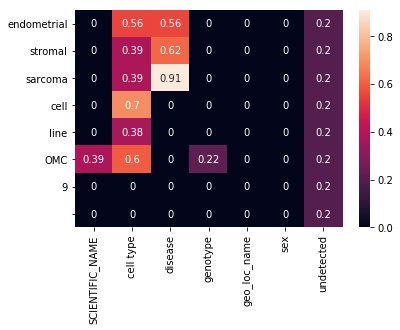

In [263]:
sns.heatmap(scoreDf,annot=True)

In [182]:
tokens

['endometrial', 'stromal', 'sarcoma', 'cell', 'line', 'OMC', '9', '']

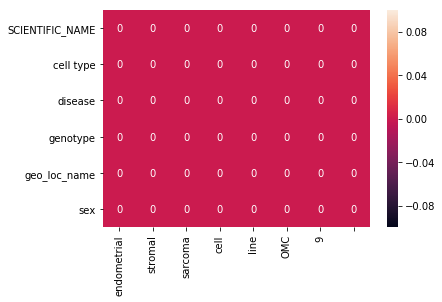

In [175]:
sns.heatmap(scoreDf.T,annot=True)

endometrial            disease
stromal                disease
sarcoma                disease
cell                 cell type
line           SCIENTIFIC_NAME
OMC                  cell type
9              SCIENTIFIC_NAME
               SCIENTIFIC_NAME
dtype: object